# Problem Statement

Music streaming platforms need to recommend relevant songs to users from millions of tracks.
This project implements and compares three recommendation approaches:

1. Baseline: Popularity-based recommendations (recommend top songs to everyone)
2. ALS (Alternating Least Squares): Advanced collaborative filtering
3. Factorization Machines: Machine learning with user features

In this project, we use the Last.fm 360K dataset, scaled to 10,000 users and 5,000 artists for computational efficiency.

Dataset: http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html (depreated)

Download link: https://zenodo.org/record/6090214/files/lastfm-dataset-360K.tar.gz

## Data Loading

In [1]:
!curl -L -o lastfm-dataset-360K.tar.gz https://zenodo.org/records/6090214/files/lastfm-dataset-360K.tar.gz

# Extract
!tar -xzf lastfm-dataset-360K.tar.gz

# Remove tar file
!rm lastfm-dataset-360K.tar.gz

data_path = 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542M  100  542M    0     0   527k      0  0:17:33  0:17:33 --:--:--  536k


In [2]:
import pandas as pd

# Load
df = pd.read_csv(data_path, sep='\t', header=None,
                 names=['user_id', 'artist_id', 'artist_name', 'play_count'])

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"Unique artists: {df['artist_id'].nunique():,}")
print(f"Play count range: {df['play_count'].min()} - {df['play_count'].max()}")

df.head()

Total interactions: 17,535,655
Unique users: 358,868
Unique artists: 160,112
Play count range: 0 - 419157


,user_id,artist_id,artist_name,play_count
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


## Visualize and Scale the Data

Visualizations of user play counts, artist popularity, and user activity distributions.

In [3]:
# User activity analysis
user_activity = df.groupby('user_id').agg({
    'artist_id': 'count',      # number of different artists
    'play_count': 'sum'        # total plays
}).rename(columns={'artist_id': 'num_artists', 'play_count': 'total_plays'})

print("User Activity Stats:")
print(f"Average artists per user: {user_activity['num_artists'].mean():.1f}")
print(f"Median artists per user: {user_activity['num_artists'].median()}")
print(f"Most active user: {user_activity['num_artists'].max()} artists")
print(f"Least active user: {user_activity['num_artists'].min()} artists")

# Artist popularity analysis
artist_popularity = df.groupby('artist_id').agg({
    'user_id': 'count',        # number of different users
    'play_count': 'sum'        # total plays
}).rename(columns={'user_id': 'num_listeners', 'play_count': 'total_plays'})

print("\nArtist Popularity Stats:")
print(f"Average listeners per artist: {artist_popularity['num_listeners'].mean():.1f}")
print(f"Median listeners per artist: {artist_popularity['num_listeners'].median()}")
print(f"Most popular artist: {artist_popularity['num_listeners'].max()} listeners")
print(f"Least popular artist: {artist_popularity['num_listeners'].min()} listeners")

User Activity Stats:
Average artists per user: 48.2
Median artists per user: 48.0
Most active user: 165 artists
Least active user: 0 artists

Artist Popularity Stats:
Average listeners per artist: 108.1
Median listeners per artist: 6.0
Most popular artist: 77254 listeners
Least popular artist: 1 listeners


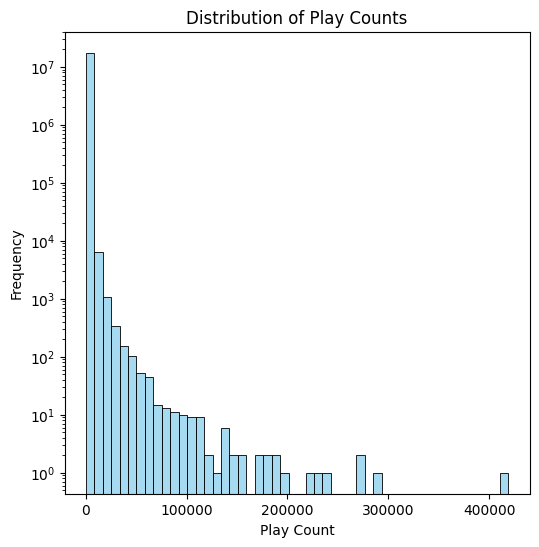

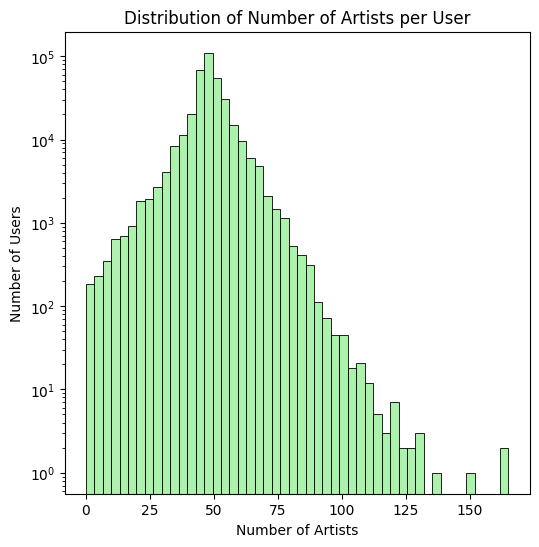

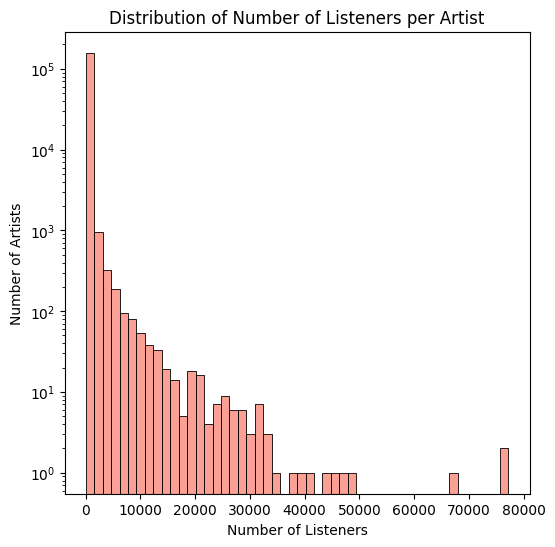

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate user activity (number of unique artists per user)
user_activity = df.groupby('user_id')['artist_id'].nunique().reset_index(name='num_artists')

# Calculate artist popularity (number of unique listeners per artist)
artist_popularity = df.groupby('artist_id')['user_id'].nunique().reset_index(name='num_listeners')

# Visualize play count distribution
plt.figure(figsize=(6, 6))
sns.histplot(df['play_count'], bins=50, kde=False, color='skyblue')
plt.title('Distribution of Play Counts')
plt.xlabel('Play Count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

# Visualize user activity distribution
plt.figure(figsize=(6, 6))
sns.histplot(user_activity['num_artists'], bins=50, kde=False, color='lightgreen')
plt.title('Distribution of Number of Artists per User')
plt.xlabel('Number of Artists')
plt.ylabel('Number of Users')
plt.yscale('log')
plt.show()

# Visualize artist popularity distribution
plt.figure(figsize=(6, 6))
sns.histplot(artist_popularity['num_listeners'], bins=50, kde=False, color='salmon')
plt.title('Distribution of Number of Listeners per Artist')
plt.xlabel('Number of Listeners')
plt.ylabel('Number of Artists')
plt.yscale('log')
plt.show()

## Filter and Scale

In [5]:
# Filter users with at least 5 unique artists
user_counts = df.groupby('user_id').size()
active_users = user_counts[user_counts >= 5].index
df_filtered = df[df['user_id'].isin(active_users)]

# Filter artists with at least 5 unique listeners
artist_counts = df_filtered.groupby('artist_id').size()
popular_artists = artist_counts[artist_counts >= 5].index
df_filtered = df_filtered[df_filtered['artist_id'].isin(popular_artists)]

# Scale down to the top 20,000 users
top_users = df_filtered['user_id'].value_counts().head(20000).index
df_scaled = df_filtered[df_filtered['user_id'].isin(top_users)]


print(f"Final scaled data: {len(df_scaled):,} interactions")
print(f"Users: {df_scaled['user_id'].nunique():,}")
print(f"Artists: {df_scaled['artist_id'].nunique():,}")

Final scaled data: 1,357,087 interactions
Users: 20,000
Artists: 66,959


## Preprocessing

In [6]:
from scipy.sparse import csr_matrix

# Create user and artist mappings
user_mapping = {user: idx for idx, user in enumerate(df_scaled['user_id'].unique())}
artist_mapping = {artist: idx for idx, artist in enumerate(df_scaled['artist_id'].unique())}

# Map IDs to indices
user_mapping = {user: idx for idx, user in enumerate(df_scaled['user_id'].unique())}
artist_mapping = {artist: idx for idx, artist in enumerate(df_scaled['artist_id'].unique())}

df_scaled['user_idx'] = df_scaled['user_id'].map(user_mapping)
df_scaled['artist_idx'] = df_scaled['artist_id'].map(artist_mapping)

# Create sparse matrix
rows = df_scaled['user_idx'].values
cols = df_scaled['artist_idx'].values
data = df_scaled['play_count'].values
sparse_matrix = csr_matrix((data, (rows, cols)),
                           shape=(len(user_mapping), len(artist_mapping)))

# Sparse Matrix Statistics
print(f"\nSparse Matrix Statistics:")
print(f"Shape: {sparse_matrix.shape}")
print(f"Total possible entries: {sparse_matrix.shape[0] * sparse_matrix.shape[1]:,}")
print(f"Non-zero entries: {sparse_matrix.nnz:,}")
sparsity_percent = (1 - sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1])) * 100
print(f"Sparsity: {sparsity_percent:.2f}%")
print(f"Density: {100 - sparsity_percent:.2f}%")

/tmp/ipython-input-1383041103.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['user_idx'] = df_scaled['user_id'].map(user_mapping)



Sparse Matrix Statistics:
Shape: (20000, 66959)
Total possible entries: 1,339,180,000
Non-zero entries: 1,357,032
Sparsity: 99.90%
Density: 0.10%


/tmp/ipython-input-1383041103.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['artist_idx'] = df_scaled['artist_id'].map(artist_mapping)


## Train/Test Split

In [7]:
import numpy as np

# Split into train and test sets
train_matrix = sparse_matrix.copy()
test_interactions = []

test_ratio = 0.2 # 20% for testing
min_interactions = 5  # only consider users with at least 5 interactions

for user_idx in range(sparse_matrix.shape[0]):
    user_interactions = sparse_matrix.getrow(user_idx)
    nonzero_items = user_interactions.nonzero()[1]

    if len(nonzero_items) >= min_interactions:
        n_test = max(1, int(len(nonzero_items) * test_ratio))
        test_items = np.random.choice(nonzero_items, n_test, replace=False)

        for item_idx in test_items:
            test_interactions.append({
                'user_idx': user_idx,
                'item_idx': item_idx,
                'rating': sparse_matrix[user_idx, item_idx]
            })
            train_matrix[user_idx, item_idx] = 0

train_matrix.eliminate_zeros()

print(f"\nTrain Matrix Statistics:")
print(f"Shape: {train_matrix.shape}")
print(f"Total possible entries: {train_matrix.shape[0] * train_matrix.shape[1]:,}")
print(f"Non-zero entries: {train_matrix.nnz:,}")
train_sparsity = (1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1])) * 100
print(f"Train set sparsity: {train_sparsity:.2f}%")


Train Matrix Statistics:
Shape: (20000, 66959)
Total possible entries: 1,339,180,000
Non-zero entries: 1,093,796
Train set sparsity: 99.92%


In [8]:
# Check for data leakage
assert train_matrix.nnz + len(test_interactions) == sparse_matrix.nnz, "Data leakage detected"

# Check sparsity
train_sparsity = (1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1])) * 100
print(f"Train set sparsity: {train_sparsity:.2f}%")

# Check for cold-start users
train_user_counts = np.array(train_matrix.sum(axis=1)).flatten()
cold_start_users = np.sum(train_user_counts == 0)
print(f"Cold-start users: {cold_start_users}")

Train set sparsity: 99.92%
Cold-start users: 0


## Model Implementation and Training

We'll implement two advanced recommendation approaches:
1. **Baseline**: Popularity-based recommendations for comparison
2. **ALS (Alternating Least Squares)**: Matrix factorization optimized for implicit feedback

### Baseline Model: Popularity-Based Recommendations

First, let's establish our baseline by identifying the most popular artists based on total play counts across all training users.

In [9]:
# Calculate artist popularity from training data
artist_popularity = np.array(train_matrix.sum(axis=0)).flatten()

# Get top artists for baseline recommendations
n_recommendations = 10
top_artists_baseline = np.argsort(artist_popularity)[::-1][:n_recommendations]

print("Baseline Model - Most Popular Artists:")
for i, artist_idx in enumerate(top_artists_baseline):
    plays = artist_popularity[artist_idx]
    print(f"  {i+1}. Artist {artist_idx}: {plays:,.0f} total plays")

Baseline Model - Most Popular Artists:
  1. Artist 156: 1,010,803 total plays
  2. Artist 305: 734,360 total plays
  3. Artist 816: 542,673 total plays
  4. Artist 344: 490,337 total plays
  5. Artist 421: 444,171 total plays
  6. Artist 674: 422,973 total plays
  7. Artist 304: 422,652 total plays
  8. Artist 2425: 361,215 total plays
  9. Artist 134: 347,791 total plays
  10. Artist 154: 342,197 total plays


### ALS Model: Collaborative Filtering

ALS (Alternating Least Squares) is a matrix factorization technique that learns latent user and item factors by alternately optimizing user and item representations. It's particularly well-suited for implicit feedback data like play counts.

Key advantages:
- Handles sparse matrices efficiently
- Optimized for implicit feedback (play counts vs explicit ratings)
- Scalable to large datasets

In [10]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=10855841 sha256=21759cb7d5fc6c886fbccf98bbadaafb46ffce74fbb2632c9bd8a2c38a64595b
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


In [11]:
import time
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm

def quick_evaluate(model, test_sample, k=10):
    """
      Quick evaluation on sample of test data for hyperparameter search.

      Args:
          model: Trained ALS model
          test_sample (list): Test interactions
          k (int): Number of recommendations

      Returns:
          float: Average precision@k across sampled users
    """
    precisions = []

    # Sample 1000 users for fast evaluation
    user_test_items = {}
    for interaction in test_sample:
        user_idx = interaction['user_idx']
        if user_idx not in user_test_items:
            user_test_items[user_idx] = []
        user_test_items[user_idx].append(interaction['item_idx'])
        if len(user_test_items) >= 1000:
            break

    for user_idx, true_items in user_test_items.items():
        try:
            user_items = train_matrix[user_idx].tocsr()
            recs, _ = model.recommend(userid=user_idx, user_items=user_items, N=k)
            hits = len(set(recs) & set(true_items))
            precisions.append(hits / k)
        except:
            precisions.append(0)

    return np.mean(precisions)

# Parameter search space
param_space = {
    'factors': [30, 50, 70, 100],
    'regularization': [0.001, 0.01, 0.05, 0.1],
    'iterations': [10, 15, 20],
    'alpha': [0.5, 1.0, 2.0, 5.0]
}

# Random search configuration
n_trials = 12
results = []

print(f"Random Hyperparameter Search: {n_trials} trials")
print("-" * 60)

for trial in tqdm(range(n_trials), desc="Searching hyperparameters", ncols=80):
    # Sample random parameters
    params = {
        'factors': np.random.choice(param_space['factors']),
        'regularization': np.random.choice(param_space['regularization']),
        'iterations': np.random.choice(param_space['iterations']),
        'alpha': np.random.choice(param_space['alpha']),
        'random_state': 42
    }

    # Train and evaluate
    start = time.time()
    model = AlternatingLeastSquares(**params)
    model.fit(train_matrix.tocsr(), show_progress=False)
    precision = quick_evaluate(model, test_interactions, k=10)
    train_time = time.time() - start

    tqdm.write(f"Trial {trial+1:2d}: P@10={precision:.4f} | "
               f"f={params['factors']:3d} r={params['regularization']:.3f} "
               f"i={params['iterations']:2d} a={params['alpha']:.1f} | {train_time:.1f}s")

    results.append({
        **params,
        'precision': precision,
        'train_time': train_time
    })

# Results summary
print("\n" + "=" * 60)
results_df = pd.DataFrame(results).sort_values('precision', ascending=False)
print("Top 3 Configurations:")
print(results_df[['factors', 'regularization', 'iterations', 'alpha', 'precision']].head(3).to_string(index=False))

# Best parameters
best = results_df.iloc[0]
print("\n" + "=" * 60)
print("Best Parameters:")
print(f"  factors={int(best['factors'])}, regularization={best['regularization']}, "
      f"iterations={int(best['iterations'])}, alpha={best['alpha']}")
print(f"  Validation Precision@10: {best['precision']:.4f}")
print("=" * 60)

# Train final model with best parameters
als_model = AlternatingLeastSquares(
    factors=int(best['factors']),
    regularization=best['regularization'],
    iterations=int(best['iterations']),
    alpha=best['alpha'],
    random_state=42
)
als_model.fit(train_matrix.tocsr(), show_progress=True)
print("Training complete.")

/usr/local/lib/python3.12/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/tmp/pip-install-3_1r3os0/implicit_94401f4e88f44c80b4eee93486205df5/./implicit/gpu/utils.h:71)'
  warnings.warn(


Random Hyperparameter Search: 12 trials
------------------------------------------------------------


Searching hyperparameters:   0%|                         | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
Searching hyperparameters:   8%|█▍               | 1/12 [00:20<03:46, 20.63s/it]

Trial  1: P@10=0.1055 | f= 70 r=0.050 i=15 a=2.0 | 20.6s


Searching hyperparameters:  17%|██▊              | 2/12 [00:29<02:18, 13.89s/it]

Trial  2: P@10=0.1034 | f= 70 r=0.050 i=10 a=2.0 | 9.2s


Searching hyperparameters:  25%|████▎            | 3/12 [00:45<02:10, 14.51s/it]

Trial  3: P@10=0.0838 | f= 70 r=0.001 i=20 a=5.0 | 15.2s


Searching hyperparameters:  33%|█████▋           | 4/12 [01:01<02:03, 15.39s/it]

Trial  4: P@10=0.1318 | f= 70 r=0.100 i=20 a=0.5 | 16.7s


Searching hyperparameters:  42%|███████          | 5/12 [01:15<01:42, 14.71s/it]

Trial  5: P@10=0.0721 | f= 30 r=0.001 i=20 a=5.0 | 13.5s


Searching hyperparameters:  50%|████████▌        | 6/12 [01:30<01:28, 14.82s/it]

Trial  6: P@10=0.0838 | f= 70 r=0.001 i=20 a=5.0 | 15.0s


Searching hyperparameters:  58%|█████████▉       | 7/12 [01:49<01:20, 16.12s/it]

Trial  7: P@10=0.0916 | f=100 r=0.050 i=20 a=5.0 | 18.8s


Searching hyperparameters:  67%|███████████▎     | 8/12 [01:59<00:57, 14.41s/it]

Trial  8: P@10=0.0826 | f=100 r=0.050 i=10 a=5.0 | 10.7s


Searching hyperparameters:  75%|████████████▊    | 9/12 [02:15<00:44, 14.71s/it]

Trial  9: P@10=0.1247 | f=100 r=0.010 i=15 a=1.0 | 15.4s


Searching hyperparameters:  83%|█████████████▎  | 10/12 [02:31<00:30, 15.16s/it]

Trial 10: P@10=0.0896 | f=100 r=0.100 i=15 a=5.0 | 16.2s


Searching hyperparameters:  92%|██████████████▋ | 11/12 [02:49<00:16, 16.08s/it]

Trial 11: P@10=0.1098 | f=100 r=0.001 i=20 a=2.0 | 18.2s


Searching hyperparameters: 100%|████████████████| 12/12 [03:00<00:00, 15.03s/it]

Trial 12: P@10=0.1058 | f=100 r=0.010 i=10 a=2.0 | 10.8s

Top 3 Configurations:
 factors  regularization  iterations  alpha  precision
      70           0.100          20    0.5     0.1318
     100           0.010          15    1.0     0.1247
     100           0.001          20    2.0     0.1098

Best Parameters:
  factors=70, regularization=0.1, iterations=20, alpha=0.5
  Validation Precision@10: 0.1318


  0%|          | 0/20 [00:00<?, ?it/s]

Training complete.


## Recommendation Generation Functions

We'll implement functions to generate recommendations from both our baseline and ALS models, then evaluate their performance using standard recommendation metrics.

In [12]:
def get_baseline_recommendations(k=10):
    """Return top K popular artists."""
    return top_artists_baseline[:k]

def get_als_recommendations(user_idx, k=10):
    """
    Get personalized ALS recommendations for a user.

    Args:
        user_idx: user index (0 to n_users-1)
        k: number of recommendations

    Returns:
        artist_indices: array of recommended artist IDs
        scores: prediction scores
    """
    try:
        # Get user's listening history (for filtering)
        user_items = train_matrix[user_idx].tocsr()

        recs, scores = als_model.recommend(
            userid=user_idx,
            user_items=user_items,
            N=k,
            filter_already_liked_items=True
        )
        return recs, scores

    except Exception as e:
        print(f"Error getting recommendations for user {user_idx}: {e}")
        # Fallback to baseline
        return np.array([]), np.array([])

# Test the functions
print("Testing recommendation functions...")
test_user = 0
baseline_recs = get_baseline_recommendations(5)
als_recs, als_scores = get_als_recommendations(test_user, 5)

print(f"Baseline recommendations: {baseline_recs}")
print(f"ALS recommendations for user {test_user}: {als_recs}")
print(f"ALS scores: {als_scores}")

Testing recommendation functions...
Baseline recommendations: [156 305 816 344 421]
ALS recommendations for user 0: [ 264  283 8748   27 1217]
ALS scores: [1.4489456 1.2920336 1.2068331 1.1972021 1.1942244]


## Model Evaluation and Comparison

Now we'll evaluate both models on our test set and compare their performance across multiple metrics.

In [13]:
def evaluate_recommendations(model_name, get_recs_func, test_interactions, k=10):
    """
    Evaluate recommendation quality using multiple metrics.

    Args:
        model_name (str): Name of the model being evaluated
        get_recs_func (function): Function that generates recommendations
                                   For baseline: takes only k
                                   For other models: takes (user_idx, k)
        test_interactions (list): List of test interaction dictionaries with keys:
                                  'user_idx', 'item_idx', 'rating'
        k (int): Number of recommendations to evaluate (default: 10)

    Returns:
        dict: Dictionary containing evaluation metrics:
              - precision: Average precision@k across all users
              - recall: Average recall@k across all users
              - ndcg: Average NDCG@k across all users
              - coverage: Fraction of items recommended at least once
              - name: Model name string
    """
    print(f"\nEvaluating {model_name}...")

    # Group test items by user
    user_test_items = {}
    for interaction in test_interactions:
        user_idx = interaction['user_idx']
        artist_idx = interaction['item_idx']
        if user_idx not in user_test_items:
            user_test_items[user_idx] = []
        user_test_items[user_idx].append(artist_idx)

    print(f"  Evaluating on {len(user_test_items)} users")

    # Initialize metric lists
    precisions = []
    recalls = []
    ndcgs = []
    all_recommended = set()

    for user_idx, true_items in user_test_items.items():
        # Get recommendations based on model type
        if model_name == "Baseline":
            recs = get_recs_func(k)
        else:
            recs, _ = get_recs_func(user_idx, k)

        # Ensure recommendations are valid indices
        recs = np.array(recs)
        valid_recs = recs[recs < train_matrix.shape[1]]

        # Calculate hits
        rec_set = set(valid_recs)
        true_set = set(true_items)
        hits = len(rec_set & true_set)

        # Precision@k: fraction of recommendations that are relevant
        precision = hits / k if k > 0 else 0
        precisions.append(precision)

        # Recall@k: fraction of relevant items that are recommended
        recall = hits / len(true_set) if len(true_set) > 0 else 0
        recalls.append(recall)

        # NDCG@k: ranking quality metric (relevant items at top positions score higher)
        dcg = 0.0
        for i, item in enumerate(valid_recs[:k]):
            if item in true_set:
                dcg += 1.0 / np.log2(i + 2)

        idcg = 0.0
        for i in range(min(len(true_set), k)):
            idcg += 1.0 / np.log2(i + 2)

        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcgs.append(ndcg)

        # Track all recommended items for coverage
        all_recommended.update(valid_recs)

    # Calculate average metrics
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_ndcg = np.mean(ndcgs)
    coverage = len(all_recommended) / train_matrix.shape[1]

    print(f"  Precision@{k}: {avg_precision:.4f}")
    print(f"  Recall@{k}: {avg_recall:.4f}")
    print(f"  NDCG@{k}: {avg_ndcg:.4f}")
    print(f"  Coverage: {coverage:.4f}")

    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'ndcg': avg_ndcg,
        'coverage': coverage,
        'name': model_name
    }

In [14]:
# Evaluate baseline
baseline_results = evaluate_recommendations(
    "Baseline",
    get_baseline_recommendations,
    test_interactions,
    k=10
)

# Evaluate ALS
als_results = evaluate_recommendations(
    "ALS",
    get_als_recommendations,
    test_interactions,
    k=10
)

# Compare results
print(f"\n{'Metric':<15} {'Baseline':<12} {'ALS':<12} {'Improvement'}")
print("-"*60)
for metric in ['precision', 'recall', 'ndcg', 'coverage']:
    base = baseline_results[metric]
    als = als_results[metric]
    improvement = ((als - base) / base * 100) if base > 0 else 0
    print(f"{metric.capitalize():<15} {base:<12.4f} {als:<12.4f} {improvement:>+7.1f}%")


Evaluating Baseline...
  Evaluating on 20000 users
  Precision@10: 0.0292
  Recall@10: 0.0224
  NDCG@10: 0.0328
  Coverage: 0.0001

Evaluating ALS...
  Evaluating on 20000 users
  Precision@10: 0.1380
  Recall@10: 0.1059
  NDCG@10: 0.1554
  Coverage: 0.0669

Metric          Baseline     ALS          Improvement
------------------------------------------------------------
Precision       0.0292       0.1380        +373.2%
Recall          0.0224       0.1059        +372.4%
Ndcg            0.0328       0.1554        +373.8%
Coverage        0.0001       0.0669       +44690.0%


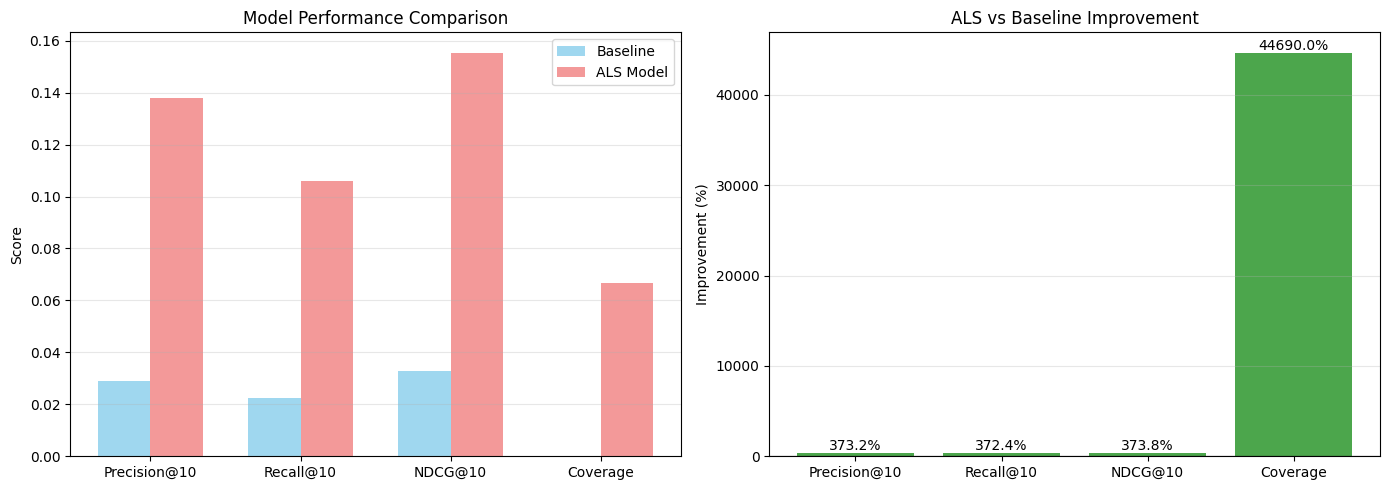

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Performance comparison
metrics = ['Precision@10', 'Recall@10', 'NDCG@10', 'Coverage']
baseline_vals = [baseline_results['precision'], baseline_results['recall'], baseline_results['ndcg'], baseline_results['coverage']]
als_vals = [als_results['precision'], als_results['recall'], als_results['ndcg'], als_results['coverage']]


x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, baseline_vals, width, label='Baseline', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, als_vals, width, label='ALS Model', alpha=0.8, color='lightcoral')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Improvement percentages
improvements = []
for base, als in zip(baseline_vals, als_vals):
    imp = ((als - base) / base * 100) if base > 0 else 0
    improvements.append(imp)

colors = ['green' if x > 0 else 'red' for x in improvements]
bars = axes[1].bar(metrics, improvements, color=colors, alpha=0.7)
axes[1].set_ylabel('Improvement (%)')
axes[1].set_title('ALS vs Baseline Improvement')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, improvements):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + (2 if height > 0 else -5),
                f'{val:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

## Sample Recommendations Analysis

Let's examine actual recommendations for a sample user to understand the difference between baseline and collaborative filtering approaches.

In [16]:
sample_user = 0

# User's profile
user_artists = train_matrix[sample_user].nonzero()[1]
total_plays = train_matrix[sample_user].sum()

print(f"Sample User {sample_user} Profile:")
print(f"  Artists listened to: {len(user_artists)}")
print(f"  Total plays: {total_plays}")

# Get recommendations
baseline_recs = get_baseline_recommendations(5)
als_recs, als_scores = get_als_recommendations(sample_user, 5)

print(f"\nBaseline Recommendations (Same for Everyone):")
for i, artist_idx in enumerate(baseline_recs):
    plays = int(artist_popularity[artist_idx])
    print(f"  {i+1}. Artist {artist_idx} ({plays:,} total plays)")

print(f"\nALS Recommendations (Personalized for User {sample_user}):")
for i, (artist_idx, score) in enumerate(zip(als_recs, als_scores)):
    print(f"  {i+1}. Artist {artist_idx} (score: {score:.3f})")

# Check against test set
user_test_items = [item['item_idx'] for item in test_interactions if item['user_idx'] == sample_user]
if user_test_items:
    baseline_hits = len(set(baseline_recs) & set(user_test_items))
    als_hits = len(set(als_recs) & set(user_test_items))
    print(f"\nActual Relevance (Test Set Hits):")
    print(f"  Baseline: {baseline_hits}/5")
    print(f"  ALS: {als_hits}/5")

Sample User 0 Profile:
  Artists listened to: 52
  Total plays: 13440

Baseline Recommendations (Same for Everyone):
  1. Artist 156 (1,010,803 total plays)
  2. Artist 305 (734,360 total plays)
  3. Artist 816 (542,673 total plays)
  4. Artist 344 (490,337 total plays)
  5. Artist 421 (444,171 total plays)

ALS Recommendations (Personalized for User 0):
  1. Artist 264 (score: 1.449)
  2. Artist 283 (score: 1.292)
  3. Artist 8748 (score: 1.207)
  4. Artist 27 (score: 1.197)
  5. Artist 1217 (score: 1.194)

Actual Relevance (Test Set Hits):
  Baseline: 0/5
  ALS: 1/5
